In [1]:
# sklearn Data
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
from sklearn import datasets

# sklearn Models
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import (
    WhiteKernel,
    RBF,
    ExpSineSquared,
    Matern,
    Sum,
    Product,
    Exponentiation,
    RationalQuadratic,
    ConstantKernel,
)

# sklearn Metrics
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.metrics import accuracy_score


# sklearn Utils
from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, SplineTransformer
from scipy.stats import entropy


import numpy as np
from numpy.random import default_rng
import random

np.random.seed(42)

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerTuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf

try:
    from celluloid import Camera
except ModuleNotFoundError:
    %pip install -qq celluloid
    from celluloid import Camera

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

try:
    import modAL
except ModuleNotFoundError:
    %pip install -qq modAL
    import modAL


from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import margin_sampling
from modAL.disagreement import max_std_sampling

from modAL.uncertainty import classifier_entropy
from modAL.uncertainty import classifier_margin
from modAL.uncertainty import classifier_uncertainty
from modAL.disagreement import consensus_entropy_sampling
from modAL.disagreement import KL_max_disagreement

from modAL.models import ActiveLearner
from modAL.utils.data import modALinput
from modAL.models import Committee
from modAL.models import CommitteeRegressor


from typing import Callable
from typing import Tuple
from typing import Optional
import warnings
from typing import List

from IPython.display import HTML
from functools import reduce
import operator

2022-07-18 10:03:09.929583: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-18 10:03:09.965700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-18 10:03:09.965713: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [34]:
# Default RC parms for grid and line plot
p = plt.rcParams

# Grid Setting
p["grid.color"] = "#999999"
p["grid.linestyle"] = "--"

# Markersize setting for scatter
if pml.is_latexify_enabled():
    p["lines.markersize"] = 3
    p["lines.markeredgewidth"] = 1
    p["lines.linewidth"] = 1.5
    p["grid.linewidth"] = 0.5
else:
    p["lines.markersize"] = 5
    p["lines.markeredgewidth"] = 1.5
    p["lines.linewidth"] = 2

In [5]:
def model_acc_err(
    model: BaseEstimator,
    problem_type: str,
    X_data: np.ndarray,
    y_data: np.ndarray,
    query_type: str,
) -> float:
    """
    Based on problem type return accuracy score or rmse for the fitted model

    Args:
    ----------
    model :
        The fitted model

    problem_type :
        Classification or Regression Problem

    X_data :
        Features for test data

    y_data :
        Labels for test data

    query_type:
        QBC, uncetanity, random

    Returns:
    ----------
    acc :
        Accuracy Score

    rmse :
        Root Mean sqaure error
    """

    if problem_type == "Classification":
        y_pred = model.predict(X_data)
        acc = accuracy_score(y_data, y_pred)
        return acc
    else:
        # Return Standard deviation for regression problem
        if query_type != "QBC":
            y_pred, y_std = model.predict(X_data, return_std=True)
            rmse = mean_squared_error(y_data, y_pred, squared=False)
            return rmse, y_std
        else:
            y_pred = model.predict(X_data)
            rmse = mean_squared_error(y_data, y_pred, squared=False)
            return rmse

In [47]:
def setup_committe(model_list: List[BaseEstimator], X_train: np.ndarray, y_train: np.ndarray) -> List[ActiveLearner]:
    """
    Create and return a list of active learners

    Args:
    ----------
    model_list :
        The list of models to be transformed active learners
        and to be included in the committee

    Returns:
    ----------
    learner_list:
        List of active learners

    X_train:
        Features of train data

    y_train:
        Labels of train data

    """

    learner_list = []

    for model in model_list:

        # initializing learner
        learner = ActiveLearner(
            estimator=model,
            X_training=X_train.copy(),
            y_training=y_train.copy(),
        )

        learner_list.append(learner)

    return learner_list

In [60]:
def QBC(
    sampling: Callable,
    committe_list: list,
    problem_type: str,
    n_queries: int,
    X_pool: np.ndarray,
    y_pool: np.ndarray,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
) -> dict:
    """
    Active Learning Loop for QBC

    Args:
    ----------
    sampling :
        The query stratergy function used for sampling

    committe_list :
        A list of members for the committe

    problem_type :
        Classification or Regression Problem

    n_queries :
        The number of queries

    X_pool:
        Features pool data

    y_pool:
        Labels pool data

    X_train:
        Features train data

    y_train:
        Labels train data

    X_test:
        Features test data

    y_train:
        Labels test data


    Returns:
    ----------
    data_dict :
        Dictionary with log of all the points queried along with
        other info
    """

    # Make a copy of pool data
    X_act_pool = X_pool.copy()
    y_act_pool = y_pool.copy()

    # Dictionary to store useful data for plotting
    data_dict = {
        "score": [],
        "pool": {"X": [X_act_pool], "y": [y_act_pool]},
        "train": {"X": [X_train], "y": [y_train]},
        "query_sample": {"X": [], "y": []},
    }

    # Setup Committe
    learner_list = setup_committe(committe_list, X_train, y_train)

    if problem_type == "Classification":
        committe = Committee(learner_list=learner_list, query_strategy=sampling)
    else:
        committe = CommitteeRegressor(learner_list=learner_list, query_strategy=sampling)

    # Scores on initial train data
    score = model_acc_err(committe, problem_type, X_test, y_test, "QBC")
    data_dict["score"].append(score)

    # Active Learning loop
    for i in range(n_queries):
        query_idx, _ = committe.query(X_act_pool)

        # Store queried sample
        data_dict["query_sample"]["X"].append(X_act_pool[query_idx])
        data_dict["query_sample"]["y"].append(y_act_pool[query_idx])

        # Teach committe
        committe.teach(X=X_act_pool[query_idx], y=y_act_pool[query_idx])

        # remove queried instance from pool
        X_act_pool = np.delete(X_act_pool, query_idx, axis=0)
        y_act_pool = np.delete(y_act_pool, query_idx, axis=0)

        # Keep a track of pool
        data_dict["pool"]["X"].append(X_act_pool)
        data_dict["pool"]["y"].append(y_act_pool)

        # Log the score/error
        score = model_acc_err(committe, problem_type, X_test, y_test, "QBC")
        data_dict["score"].append(score)

    return data_dict

In [56]:
def uncertanity_sample_comp(
    sampling: Callable,
    model: BaseEstimator,
    strat: str,
    n_queries: int,
    problem_type: str,
    X_pool: np.ndarray,
    y_pool: np.ndarray,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
) -> dict:

    """
    Based on problem type return accuracy score or rmse for the fitted model

    Args:
    ----------
    sampling :
        The query stratergy function used for sampling

    model :
        The machine learning model

    strat :
        Name of query stratergy

    n_queries :
        The number for iteration to run for each sampling technique

    problem_type :
        Classification or Regression Problem

    X_pool:
        Features pool data

    y_pool:
        Labels pool data

    X_train:
        Features train data

    y_train:
        Labels train data

    Returns:
    ----------
    data_dict :
        Dictionary with log of all the points queried along with
        other info
    """

    # Declare Model for active learning
    active_model = modAL.models.ActiveLearner(
        estimator=model, query_strategy=sampling, X_training=X_train, y_training=y_train
    )

    # Make a copy of Pool data
    X_act_pool = X_pool.copy()
    y_act_pool = y_pool.copy()

    # Dictionary to store history of query points and pool, helpful for graph plotting
    data_dict = {
        "score": [],
        "std_dev_pts": [],
        "pool": {"X": [X_act_pool], "y": [y_act_pool]},
        "train": {"X": [X_train], "y": [y_train]},
        "query_sample": {"X": [], "y": []},
    }

    # Intial score on train data
    if problem_type == "Classification":
        score = model_acc_err(active_model, problem_type, X_test, y_test, "Uncertanity")
        data_dict["score"].append(score)
    else:
        score, y_test_std = model_acc_err(active_model, problem_type, X_test, y_test, "Uncertanity")
        data_dict["score"].append(score)
        data_dict["std_dev_pts"].append(y_test_std)

    # Active Learning loop
    while n_queries:

        # Query a Point
        query_idx, _ = active_model.query(X_act_pool, n_instances=1)

        # Log queried points
        data_dict["query_sample"]["X"].append(X_act_pool[query_idx])
        data_dict["query_sample"]["y"].append(y_act_pool[query_idx])

        # Teach the model the new queried point
        active_model.teach(X_act_pool[query_idx], y_act_pool[query_idx])

        # Delete point from pool
        X_act_pool = np.delete(X_act_pool, query_idx, axis=0)
        y_act_pool = np.delete(y_act_pool, query_idx, axis=0)

        # Log pool data
        data_dict["pool"]["X"].append(X_act_pool)
        data_dict["pool"]["y"].append(y_act_pool)

        # Log the score/error
        if problem_type == "Classification":
            score = model_acc_err(active_model, problem_type, X_test, y_test, "Uncertanity")
            data_dict["score"].append(score)
        else:
            score, y_test_std = model_acc_err(active_model, problem_type, X_test, y_test, "Uncertanity")
            data_dict["score"].append(score)
            data_dict["std_dev_pts"].append(y_test_std)

        n_queries -= 1

    return data_dict

In [57]:
def plot_data(
    sampling_dict: dict,
    n_queries: int,
    problem_type: str,
    latexify_dict: dict = {"fig_name": None, "legend_pos": "best"},
    grid_flag: bool = True,
) -> None:
    """
    Based on problem type return accuracy score or rmse for the fitted model

    Args:
    ----------
    sampling_dict :
        Dictionary with log of all the points queried along with
        other info

    n_queries :
        The number for iteration to run for each sampling technique

    problem_type :
        Classification or Regression Problem

    latexify_dict :
        Options for latexified figures

    grid_flag:
        To toggle grids on graphs

    latexify:
        Latexify function

    Returns:
    ----------
    None
    """

    # Declare figure
    fig = plt.figure()
    ax = plt.gca()

    # Toggle Grid
    ax.grid(grid_flag)

    # Number of Iterations for x-axis labels
    x_axis = np.array([i for i in range(n_queries + 1)])

    for key, value in sampling_dict.items():

        # If not random sampling just plot the score
        if value["type"] != "random":
            plt.plot(x_axis, value["score"], label=key + " sampling", marker=value["marker"])
        # If random sampling query strat, plot random accuracies along with mean accuracy or rmse
        elif value["type"] == "random":
            # Choose any n random accuracy curves
            all_random_iter = len(value["score"]) - 1
            random_choice = np.random.choice(all_random_iter, size=value["disp_randoms"], replace=False)
            # Plot random curves
            for i in random_choice:
                scores = value["score"][i]
                plt.plot(
                    x_axis,
                    scores,
                    label=key + " samples",
                    marker=value["marker"],
                    color="blueviolet",
                    alpha=0.25,
                )
            # Plot mean accuracy curve
            plt.plot(
                x_axis,
                value["mean_score"],
                label=f"Mean of {key} sampling",
                marker=value["marker"],
                color="blueviolet",
            )

    sns.despine()
    plt.xticks([i for i in range(x_axis[0], x_axis[-1] + 1, 5)])
    plt.xlabel("Number of Points queried")

    # Remove Duplicates created due to Different Random Plots
    handles, labels = ax.get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)

    # Different axes labels based on problem type
    if problem_type == "Classification":
        plt.ylabel("Accuracy")
    else:
        plt.ylabel("RMSE")

    # Custom plotting options
    if pml.is_latexify_enabled() and latexify_dict["fig_name"]:
        pml.latexify(**latexify_dict["latexify_parms"])
        plt.legend(handles=newHandles, labels=newLabels, **latexify_dict["legend_params"])
        pml.savefig(latexify_dict["fig_name"])
    else:
        plt.legend(handles=newHandles, labels=newLabels, loc="upper right", bbox_to_anchor=(1.55, 1))

    plt.show()

In [51]:
def random_sampling(model: BaseEstimator, X: modALinput, n_instances: int = 1) -> Tuple[np.ndarray, modALinput]:
    """
    Based on problem type return accuracy score or rmse for the fitted model

    Args:
    ----------
    model :
        Classification or Regression model used

    X :
        The data to query from, this would be pool data

    Returns:
    ----------
    query_idx:
        Index of queried sample

    query_sample:
        The actual queried sample
    """

    np.random.seed(None)
    indices = np.random.choice(range(X.shape[0]), size=n_instances, replace=False)
    query_idx = indices
    query_sample = X[indices]
    return query_idx, query_sample

In [52]:
def compare_sampling(
    sampling_dict_data: dict,
    problem_type: str,
    n_queries: int,
    X_pool: np.ndarray,
    y_pool: np.ndarray,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    latexify_dict={"fig_name": None, "legend_pos": "best"},
) -> None:
    """
    Based on problem type return accuracy score or rmse for the fitted model

    Args:
    ----------
    sampling_dict_data :
        Dictionary with log of all the points queried along with
        other info

    problem_type :
        Classification or Regression Problem

    n_queries :
        The number for iteration to run for each sampling technique

    latexify_dict :
        Options for latexified figures

    X_pool:
        Features pool data

    y_pool:
        Labels pool data

    X_train:
        Features train data

    y_train:
        Labels train data

    X_test:
        Features test data

    y_train:
        Labels test data


    Returns:
    ----------
    None

    """

    # Loop over each uncertanity type
    for key, value in sampling_dict_data.items():

        # For uncertanity
        if value["type"] == "uncertanity":
            uncertanity_info_dict = uncertanity_sample_comp(
                value["query_strat"],
                value["model"],
                key,
                n_queries,
                problem_type=problem_type,
                X_pool=X_pool,
                y_pool=y_pool,
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
            )
            value["score"] = uncertanity_info_dict["score"]
        elif value["type"] == "qbc":
            qbc_info_dict = QBC(
                value["query_strat"],
                value["model"],
                problem_type,
                n_queries,
                X_pool=X_pool,
                y_pool=y_pool,
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
            )
            value["score"] = qbc_info_dict["score"]
        # For Random
        else:
            for i in range(value["n_iter"]):
                uncertanity_info_dict = uncertanity_sample_comp(
                    value["query_strat"],
                    value["model"],
                    key,
                    n_queries,
                    problem_type=problem_type,
                    X_pool=X_pool,
                    y_pool=y_pool,
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test,
                )
                value["score"].append(uncertanity_info_dict["score"])

            # Mean and std dev for errors for random sampling
            err_arr = np.array(sampling_dict_data[key]["score"])
            mean_err_arr = np.mean(err_arr, axis=0)
            stddev_err_arr = np.std(err_arr, axis=0)

            sampling_dict_data[key]["mean_score"] = mean_err_arr
            sampling_dict_data[key]["std_dev"] = stddev_err_arr

    # Plot the data
    plot_data(sampling_dict_data, n_queries, problem_type, latexify_dict)

### Comparison of uncertanity sampling and random sampling

In [25]:
def make_animation_data_cls(X: Optional[np.ndarray] = None, y: Optional[np.ndarray] = None) -> Tuple[np.ndarray, ...]:
    """
    Make classification data for animation

    Args:
    ----------
    X :
        Optional, input feature data X. Must be 2-D

    y :
        Optional, input label data y

    Returns:
    ----------
    x_min :
        min value of x-axis of plot

    x_max :
        max value for x-axis of plot

    y_min :
        min value for y-axis of plot

    y_max :
        max value for y-axis of plot

    xx :
        meshgrid x coords

    yy :
        meshgrid y coords

    X_train :
        Train data features

    X_pool :
        Pool data features

    y_train :
        Train data labels

    y_pool :
        Pool data labels

    """

    # If X,y are not provided create a random classification dataset
    if isinstance(X, type(None)) and isinstance(y, type(None)):
        X, y = make_classification(
            n_samples=200,
            n_features=2,
            n_redundant=0,
            n_informative=2,
            n_clusters_per_class=1,
            n_classes=3,
            class_sep=1.2,
            random_state=0,
            flip_y=0.00,
        )
    elif not (isinstance(X, np.ndarray) and isinstance(y, np.ndarray)):
        print(f"Check if the input arguments X:{X} or y:{y} are not of type np.ndarray")
        return

    # Split data
    X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.80, random_state=42, stratify=y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, train_size=0.18, random_state=42, stratify=y_train
    )

    # step size in the mesh
    h = 0.02

    # create a mesh to plot in
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    return (
        x_min,
        x_max,
        y_min,
        y_max,
        xx,
        yy,
        X_train,
        X_pool,
        y_train,
        y_pool,
        X_test,
        y_test,
    )

In [26]:
# Get Data for classification
(
    _,
    _,
    _,
    _,
    _,
    _,
    X_train,
    X_pool,
    y_train,
    y_pool,
    X_test,
    y_test,
) = make_animation_data_cls()

/home/nitish1295/.local/lib/python3.8/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


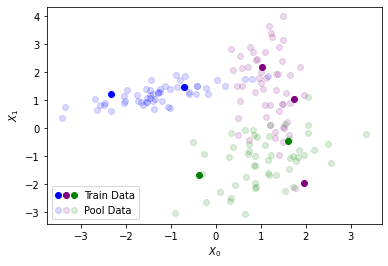

In [27]:
# Display data plot

fig = plt.figure()
ax = plt.gca()

pml.latexify(width_scale_factor=2)
class_0_pool = ax.scatter(
    X_pool[:, 0][y_pool == 0],
    X_pool[:, 1][y_pool == 0],
    c="blue",
    label="Class 0",
    alpha=0.15,
)
class_1_pool = ax.scatter(
    X_pool[:, 0][y_pool == 1],
    X_pool[:, 1][y_pool == 1],
    c="purple",
    label="Class 1",
    alpha=0.15,
)
class_2_pool = ax.scatter(
    X_pool[:, 0][y_pool == 2],
    X_pool[:, 1][y_pool == 2],
    c="green",
    label="Class 2",
    alpha=0.15,
)

# Scatter Plots for train data
class_0_train = ax.scatter(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], c="blue", zorder=2)
class_1_train = ax.scatter(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], c="purple", zorder=2)
class_2_train = ax.scatter(X_train[:, 0][y_train == 2], X_train[:, 1][y_train == 2], c="green", zorder=2)


ax.set_xlabel("$X_0$")
ax.set_ylabel("$X_1$")


if pml.is_latexify_enabled():
    legend_fontsize = 5
    ax.legend(
        [(class_0_train, class_1_train, class_2_train), (class_0_pool, class_1_pool, class_2_pool)],
        ["Train Data", "Pool Data"],
        loc="lower left",
        fontsize=legend_fontsize,
        handler_map={tuple: HandlerTuple(ndivide=None)},
    )
    pml.savefig("1D Classification Dataset")
else:
    ax.legend(
        [(class_0_train, class_1_train, class_2_train), (class_0_pool, class_1_pool, class_2_pool)],
        ["Train Data", "Pool Data"],
        loc="lower left",
        handler_map={tuple: HandlerTuple(ndivide=None)},
    )

In [28]:
committee_class_list = [RandomForestClassifier(random_state=42), LogisticRegression(random_state=42, max_iter=1000)]

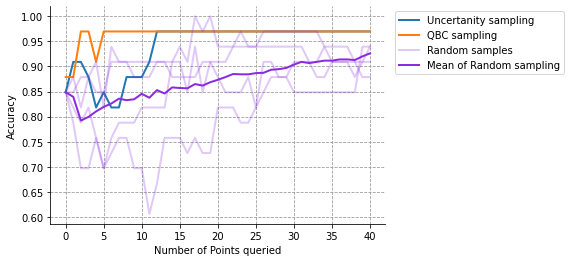

In [29]:
sampling_dict_class = {
    "Uncertanity": {
        "model": clone(RandomForestClassifier(random_state=42)),
        "query_strat": margin_sampling,
        "score": [],
        "marker": None,
        "type": "uncertanity",
    },
    "QBC": {
        "model": committee_class_list,
        "query_strat": margin_sampling,
        "score": [],
        "marker": None,
        "type": "qbc",
    },
    "Random": {
        "model": clone(RandomForestClassifier(random_state=42)),
        "query_strat": random_sampling,
        "score": [],
        "mean_score": [],
        "std_dev": [],
        "marker": None,
        "type": "random",
        "n_iter": 50,
        "disp_randoms": 4,
        "mode": "all_random",
    },
}

# Specify latexify options for accuracy plot
latexify_dict = {
    "fig_name": "Uncertanity_Sampling_Classification",
    "legend_params": {"loc": "lower right", "fontsize": 5, "framealpha": 0.5},
    "latexify_parms": {"width_scale_factor": 2},
}

compare_sampling(
    sampling_dict_class,
    "Classification",
    n_queries=40,
    X_pool=X_pool,
    y_pool=y_pool,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    latexify_dict=latexify_dict,
)

### Regression Error Plots with different Uncertanity Sampling techniques

In [61]:
def make_animation_data_reg(initial_train_size: int = 3) -> Tuple[np.ndarray, ...]:
    """
    Make data for regression plots

    Args:
    ----------
    initial_train_size :
        The initial train size for your model

    Returns:
    ----------
    X_train:
        Features train data

    y_train:
        Labels train data

    X_pool:
        Features pool data

    y_pool:
        Labels pool data

    X_test:
        Features test data

    y_test:
        Labels test data

    """

    # Sort the data to make plotting easier later
    np.random.seed(37)
    X = np.sort(-10 * np.random.rand(500) + 10)

    # Gaussian Noise
    noise = np.random.normal(0, 1, 500) * 0.4

    # Increase dims for train test split result
    X = np.expand_dims(X, axis=1)

    # Add noise and other functions
    y = np.sin(X).squeeze() + np.cos(X).squeeze() + np.sqrt(X).squeeze() + noise

    # Split for Pool and test
    X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle="False")

    # Split again for train and Pool
    X_train, X_pool, y_train, y_pool = train_test_split(
        X_pool, y_pool, train_size=initial_train_size, random_state=42, shuffle="False"
    )

    return X_test, X_train, X_pool, y_test, y_train, y_pool

In [62]:
# Create custom dataset for Regression
X_test, X_train, X_pool, y_test, y_train, y_pool = make_animation_data_reg()

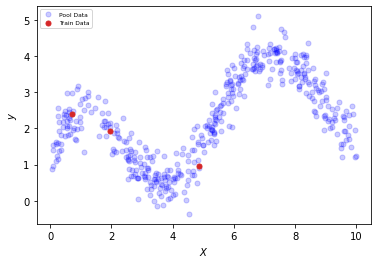

In [63]:
fig = plt.figure()
ax = plt.gca()

pml.latexify(width_scale_factor=2)
ax.scatter(X_pool, y_pool, c="blue", label="Pool Data", alpha=0.2)
ax.scatter(X_train, y_train, c="tab:red", label="Train Data")
ax.set_xlabel("$X$")
ax.set_ylabel("$y$")

if pml.is_latexify_enabled():
    legend_fontsize = 5
    ax.legend(loc="upper left", fontsize=6)
    pml.savefig("1D Regression Dataset")
else:
    ax.legend(loc="upper left", fontsize=6)

In [66]:
# Choose a model
kernel_0 = ConstantKernel(0.1) * (Matern(length_scale=0.1, nu=2.5)) + WhiteKernel(noise_level_bounds=(1e-10, 1e1))
kernel_1 = ConstantKernel(0.1) * (Matern(length_scale=0.1, nu=1.5)) + WhiteKernel(noise_level_bounds=(1e-10, 1e1))

model_0 = make_pipeline(
    StandardScaler(), GaussianProcessRegressor(kernel=kernel_0, n_restarts_optimizer=10, random_state=0)
)

model_1 = make_pipeline(
    StandardScaler(), GaussianProcessRegressor(kernel=kernel_1, n_restarts_optimizer=10, random_state=0)
)

committee_reg_list = [model_0, model_1]

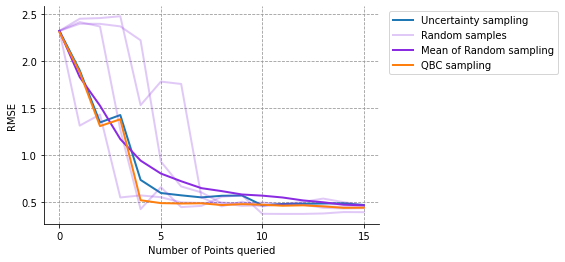

In [67]:
warnings.filterwarnings("ignore")

# Change/Add sampling stratergies in below dictionary
sampling_dict_reg = {
    "Uncertainty": {
        "model": clone(model_0),
        "query_strat": max_std_sampling,
        "score": [],
        "marker": None,
        "type": "uncertanity",
    },
    "Random": {
        "model": clone(model_0),
        "query_strat": random_sampling,
        "score": [],
        "marker": None,
        "type": "random",
        "n_iter": 25,
        "disp_randoms": 4,
        "mode": "all_random",
    },
    "QBC": {
        "model": committee_reg_list,
        "query_strat": max_std_sampling,
        "score": [],
        "marker": None,
        "type": "qbc",
    },
}

# Specify latexify options
latexify_dict = {
    "fig_name": "Uncertanity_Sampling_Regression",
    "legend_params": {"loc": "upper right", "fontsize": 5, "framealpha": 0.5},
    "latexify_parms": {"width_scale_factor": 2},
}

compare_sampling(
    sampling_dict_reg,
    "Regression",
    n_queries=15,
    X_pool=X_pool,
    y_pool=y_pool,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    latexify_dict=latexify_dict,
)

### Animation Classification

In [71]:
def uncert_results(
    model: BaseEstimator,
    uncertainty_sampling: Callable,
    problem_type: str,
    strat: str,
    n_queries: int,
    X_pool: np.ndarray,
    y_pool: np.ndarray,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
) -> Tuple[np.ndarray, ...]:
    """
    Get the uncertanity results and extract relvant data for further use

    Args:
    ----------
    model :
        The ML model to be used

    uncertainty_sampling :
        The uncertanity sampling stratergy

    problem_type :
        Classification or Regression

    strat :
        The name of the problem

    n_queries :
        The number of queries/iterations to perform

    X_pool :
        Pool data features

    y_pool :
        Pool data labels

    X_train :
        Train data features

    y_train :
        Train data labels

    Returns:
    ----------
    queries_np_X :
        The queried points

    queries_np_y :
        Corresponding labels for the queried points

    score :
        Accuracy score or RMSE for each queried point

    X_pool :
        Pool data features

    y_pool :
        Pool data labels

    st_dev_pts:
        Standard deviation of each point(Only for regression)

    """
    # Run uncertanity sampling
    uncertanity_data_dict = uncertanity_sample_comp(
        uncertainty_sampling,
        clone(model),
        strat,
        n_queries=n_queries,
        problem_type=problem_type,
        X_pool=X_pool,
        y_pool=y_pool,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )

    # Get the quried points and their corresponding labels
    queries_np_X = np.array(uncertanity_data_dict["query_sample"]["X"]).reshape(n_queries, X_train.shape[1])
    queries_np_y = np.array(uncertanity_data_dict["query_sample"]["y"]).reshape(
        n_queries,
    )

    # A list of Pool data and corresponding labels after each query has completed
    X_pool = uncertanity_data_dict["pool"]["X"]
    y_pool = uncertanity_data_dict["pool"]["y"]

    if problem_type == "Classification":
        # Get the accuracy score or RMSE calculated after each query point
        score = uncertanity_data_dict["score"]
        return queries_np_X, queries_np_y, score, X_pool, y_pool
    else:
        st_dev_pts = uncertanity_data_dict["std_dev_pts"]
        score = uncertanity_data_dict["score"]
        return queries_np_X, queries_np_y, score, X_pool, y_pool, st_dev_pts

In [72]:
def plot_countor(
    prob: np.ndarray,
    xx: np.ndarray,
    yy: np.ndarray,
    cmap: str,
    ax: mpl.axes.Axes,
    fig: mpl.figure.Figure,
):
    """
    Plot countors for the given meshgrid and probabilities

    Args:
    ----------
    prob :
        Probabilities to be displayed over the meshgrid

    xx :
        Meshgrid x-coords

    yy :
        Meshgrid y-coords

    cmap :
        Color for the countor

    ax :
        Matplotlib axes

    fig :
        Matplotlib figure

    Returns:
    ----------
    ax :
        Matplotlib axes

    fig :
        Matplotlib figure

    """

    # Mask probabilities low probabilities for a given class
    # since contours overlap, the colors look saturated
    prob = np.ma.masked_where(prob < 0.25, prob)

    # Add a countor lines and countor plot
    ax.contourf(
        xx,
        yy,
        prob,
        cmap=cmap,
        alpha=0.3,
        levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    )

    ax.contour(
        xx,
        yy,
        prob,
        cmap=cmap,
        alpha=0.4,
        linewidths=2,
        levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    )

    return fig, ax

In [73]:
def final_decision_countor(
    key: str,
    i: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_train_qry: np.ndarray,
    y_train_qry: np.ndarray,
    probs: np.ndarray,
    xx: np.ndarray,
    yy: np.ndarray,
    cmaps: list,
    X_pool: np.ndarray,
    y_pool: np.ndarray,
    save_name: str,
) -> None:

    """
    At any given instance a function to save the countour plot

    Args:
    ----------
    key :
        Query Stratergy Name

    xx :
        Meshgrid x-coords

    yy :
        Meshgrid y-coords

    cmap :
        Color for the countor

    ax :
        Matplotlib axes

    fig :
        Matplotlib figure

    Returns:
    ----------
    ax :
        Matplotlib axes

    fig :
        Matplotlib figure

    """

    # Mask probabilities less than 0.20 to make the surface plots in graph
    # more clearer, otherwise probabilities colors appear saturated
    probs = np.ma.masked_where(probs < 0.20, probs)

    # Create a figure
    pml.latexify(width_scale_factor=3)
    fig = plt.figure()
    ax = plt.gca()
    ax.grid(False)

    for prob_idx in range(probs.shape[1]):
        plot_countor(probs[:, prob_idx].reshape(xx.shape), xx, yy, cmaps[prob_idx], ax, fig)

    # Get Queried Points excluding the train data
    X_train_qry = X_train_qry[-i:]
    y_train_qry = y_train_qry[-i:]

    # Scatter plot of Pool data
    pool_pts = ax.scatter(X_pool[:, 0], X_pool[:, 1], c="darkgrey", label="Pool Points", alpha=0.75)

    # Scatter Plots for train data
    class_0_train = ax.scatter(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], c="blue", zorder=2)
    class_1_train = ax.scatter(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], c="purple", zorder=2)
    class_2_train = ax.scatter(X_train[:, 0][y_train == 2], X_train[:, 1][y_train == 2], c="green", zorder=2)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("Feature 1")

    # Setup legends and display for when queried points are shown
    if i != 0:
        class_0 = ax.scatter(
            X_train_qry[:, 0][y_train_qry == 0],
            X_train_qry[:, 1][y_train_qry == 0],
            linewidths=0.75,
            s=15,
            edgecolor="black",
            c="blue",
            zorder=3,
        )
        class_1 = ax.scatter(
            X_train_qry[:, 0][y_train_qry == 1],
            X_train_qry[:, 1][y_train_qry == 1],
            linewidths=0.75,
            s=15,
            edgecolor="black",
            c="purple",
            zorder=3,
        )
        class_2 = ax.scatter(
            X_train_qry[:, 0][y_train_qry == 2],
            X_train_qry[:, 1][y_train_qry == 2],
            linewidths=0.75,
            s=15,
            edgecolor="black",
            c="green",
            zorder=3,
        )
        ax.legend(
            [
                (class_0, class_1, class_2),
                (class_0_train, class_1_train, class_2_train),
                (pool_pts),
            ],
            ["Queried Data", "Train Data", "Pool Data"],
            loc="upper left",
            fontsize=5,
            framealpha=0.7,
            handler_map={tuple: HandlerTuple(ndivide=None)},
        )
    # Setup legends for only when train data is shown
    else:
        ax.set_ylabel("Feature 2")
        ax.legend(
            [(class_0_train, class_1_train, class_2_train), (pool_pts)],
            ["Train Data", "Pool Data"],
            loc="upper left",
            fontsize=5,
            framealpha=0.7,
            handler_map={tuple: HandlerTuple(ndivide=None)},
        )

    pml.savefig(save_name)

In [74]:
def final_decision_bound(
    key: str,
    i: int,
    X_all: np.ndarray,
    y_all: np.ndarray,
    X_train: np.ndarray,
    y_train: np.ndarray,
    predictions,
    query_x0,
    query_x1,
    xx: np.ndarray,
    yy: np.ndarray,
    cmap: list,
    save_name: str,
) -> None:

    # Setup Figure
    pml.latexify(width_scale_factor=2)
    fig = plt.figure()
    ax = plt.gca()
    ax.grid(False)

    # Create a Countorrf plot
    ax.contourf(xx, yy, predictions, cmap=cmap)

    # Display all data
    class_0 = ax.scatter(X_all[:, 0][y_all == 0], X_all[:, 1][y_all == 0], c="b")
    class_1 = ax.scatter(X_all[:, 0][y_all == 1], X_all[:, 1][y_all == 1], c="y")
    class_2 = ax.scatter(X_all[:, 0][y_all == 2], X_all[:, 1][y_all == 2], c="g")

    # Highlight train data
    train_pts = ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c="red",
        zorder=2,
        s=25,
        edgecolor="black",
        label="Train Data",
    )

    # Setup legends and display for when queried points are shown
    if i != 0:
        query_pts = ax.scatter(
            query_x0,
            query_x1,
            c="darkorange",
            marker="o",
            zorder=2,
            s=25,
            edgecolor="black",
            label="Queried Data",
        )
        ax.legend(
            [(class_0, class_1, class_2), train_pts, query_pts],
            ["Pool Data", "Train Data", "Queried Data"],
            loc="lower left",
            fontsize=6,
            framealpha=0.4,
            handler_map={tuple: HandlerTuple(ndivide=None)},
        )
    # Setup legends for only when train data is shown
    else:
        ax.legend(
            [(class_0, class_1, class_2), train_pts],
            ["Pool Data", "Train Data"],
            loc="lower left",
            fontsize=6,
            framealpha=0.4,
            handler_map={tuple: HandlerTuple(ndivide=None)},
        )

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

    pml.savefig(save_name)

In [75]:
def animate_classification(sampling_dict_class: dict, grid_row: int = 3, grid_col: int = 3, n_queries=100):
    """
    Make animations for classification

    Args:
    ----------
    sampling_dict_class :
        Dictionary to store data for all different uncertanity techniques

    grid_row:
        # of rows in plot

    grid_col:
        # of columns in plot

    n_queries:
        # of queries for uncertanity sampling

    Returns:
    ----------
    animation:
        An animation of all the plots

    """

    # Intialize Plots
    fig, ax = plt.subplots(grid_row, grid_col, figsize=(20, 15))
    camera = Camera(fig)

    # Generate relevant data
    (
        x_min,
        x_max,
        y_min,
        y_max,
        xx,
        yy,
        X_train,
        X_pool,
        y_train,
        y_pool,
        X_test,
        y_test,
    ) = make_animation_data_cls()

    # Create all data, needed for plotting later
    X_all = np.append(X_train, X_pool, axis=0)
    y_all = np.append(y_train, y_pool, axis=0)

    # Iterate over each sampling technique and store its results
    # in correspoding dictionary for later
    for uncert_key, uncert_val in sampling_dict_class.items():
        (
            uncert_val["queries_np_X"],
            uncert_val["queries_np_y"],
            uncert_val["score"],
            uncert_val["X_pool"],
            uncert_val["y_pool"],
        ) = uncert_results(
            uncert_val["model"],
            uncert_val["query_strat"],
            "Classification",
            uncert_key,
            n_queries=n_queries,
            X_pool=X_pool,
            y_pool=y_pool,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
        )

    # Loop over each iteration in each sampling stratergy
    for i in range(n_queries + 1):

        # Go over each sampling stratergy
        for col, (key, value) in enumerate(sampling_dict_class.items()):

            # If initial iteration only consider the train points else consider queried points+train points
            if i == 0:
                X_train_qry = X_train
                y_train_qry = y_train
            else:
                X_train_qry = np.append(X_train, value["queries_np_X"][:i, :], axis=0)
                y_train_qry = np.append(y_train, value["queries_np_y"][:i])

            # Fit the model
            model_qry = clone(uncert_val["model"]).fit(X_train_qry, y_train_qry)

            # Predict probabilities on meshgrid to display countors
            probs = model_qry.predict_proba(np.c_[xx.ravel(), yy.ravel()])

            # Make predictions on meshgrid to display decision bounds
            predictions = model_qry.predict(np.c_[xx.ravel(), yy.ravel()])
            predictions = predictions.reshape(xx.shape)

            # For each sampling type plot a column of 3 plots
            for row, graph_type in enumerate(["decision_countour", "decision_bound", "accuracy_line"]):

                if graph_type == "decision_bound":

                    ax[row][col].grid(False)

                    # Make a custom cmap
                    custom_cmap = ListedColormap(["#9898ff", "#fafab0", "#a0faa0"])

                    # Plot contour
                    ax[row][col].contourf(xx, yy, predictions, cmap=custom_cmap)

                    # Plot all the data indicating different classes
                    ax[row][col].scatter(
                        X_all[:, 0],
                        X_all[:, 1],
                        c=np.array(["b", "y", "g"])[y_all],
                        s=30,
                    )

                    # Highlight train data
                    ax[row][col].scatter(
                        X_train[:, 0], X_train[:, 1], c=np.array(["b", "y", "g"])[y_train], s=35, edgecolor="black"
                    )

                    # Select all the points queried till now
                    qry_pt = value["queries_np_X"][:i, :]

                    # Only display queried points when query iteration>0
                    if i != 0:
                        ax[row][col].scatter(
                            qry_pt[:, 0],
                            qry_pt[:, 1],
                            c="darkorange",
                            marker="o",
                            s=35,
                            edgecolor="black",
                        )

                    # Graph Options
                    ax[row][col].set_xlim(xx.min(), xx.max())
                    ax[row][col].set_ylim(yy.min(), yy.max())
                    ax[row][col].set_xticks(())
                    ax[row][col].set_yticks(())

                    # Take a snap of graphs at any given iteration
                    if i in [] and pml.is_latexify_enabled() and value["save_dec"]:
                        print(
                            f"Plotting Decision Boundary, the Current Stratergy is {key} and accuracy at iteration:{i} is {value['score'][i]}"
                        )
                        final_decision_bound(
                            key,
                            i,
                            X_all,
                            y_all,
                            X_train,
                            y_train,
                            predictions,
                            qry_pt[:, 0],
                            qry_pt[:, 1],
                            xx,
                            yy,
                            custom_cmap,
                            f"{value['save_dec']}_db_iter_{i}",
                        )

                elif graph_type == "decision_countour":

                    # Decision Boundary Plot using countours

                    # Color maps for countors
                    cmaps = ["Blues", "Purples", "Greens"]

                    # Plot contours for each class
                    for prob_idx in range(probs.shape[1]):
                        plot_countor(
                            probs[:, prob_idx].reshape(xx.shape),
                            xx,
                            yy,
                            cmaps[prob_idx],
                            ax[row][col],
                            fig,
                        )

                    # Plot all pool data
                    ax[row][col].scatter(value["X_pool"][0][:, 0], value["X_pool"][0][:, 1], c="darkgrey", alpha=0.3)

                    # Plot all queried data
                    ax[row][col].scatter(
                        X_train_qry[:, 0][-i:],
                        X_train_qry[:, 1][-i:],
                        c=np.array(["blue", "purple", "green"])[y_train_qry[-i:]],
                        edgecolor="black",
                        zorder=3,
                    )

                    # Plot train data
                    ax[row][col].scatter(
                        X_train[:, 0], X_train[:, 1], c=np.array(["blue", "purple", "green"])[y_train], zorder=3
                    )

                    # Plot the next queried point
                    if i != 0:
                        ax[row][col].scatter(
                            X_train_qry[:, 0][-1],
                            X_train_qry[:, 1][-1],
                            c=np.array(["blue", "purple", "green"])[y_train_qry][-1],
                            s=100,
                            edgecolor="black",
                            zorder=4,
                        )

                    # Graph options
                    ax[row][col].set_xlim(xx.min(), xx.max())
                    ax[row][col].set_ylim(yy.min(), yy.max())
                    ax[row][col].set_xticks(())
                    ax[row][col].set_yticks(())
                    ax[row][col].set_title(key, color=value["color_scheme"])

                    # Save at an any iteration
                    if i in [0, 11] and pml.is_latexify_enabled() and value["save_dec"]:
                        print(
                            f"Plotting Decision Contour, the Current Stratergy is {key} and accuracy at iteration:{i} is {value['score'][i]}"
                        )
                        final_decision_countor(
                            key,
                            i,
                            X_train,
                            y_train,
                            X_train_qry,
                            y_train_qry,
                            probs,
                            xx,
                            yy,
                            cmaps,
                            value["X_pool"][0],
                            value["y_pool"][0],
                            f"{value['save_dec']}_dc_iter_{i}",
                        )

                elif graph_type == "accuracy_line":

                    # Accuracy Plot
                    ax[row][col].grid(True)

                    # Plot accuracy curves
                    if i == 0:
                        ax[row][col].scatter([i], value["score"][i], color=value["color_scheme"])
                    else:
                        ax[row][col].plot(
                            [itr for itr in range(i + 1)],
                            value["score"][: i + 1],
                            color=value["color_scheme"],
                        )
                        ax[row][col].set_xticks([i for i in range(0, i + 1, 1)])

                    ax[row][col].set_xlabel("Number of Iterations")

                    if col == 0:
                        ax[row][col].set_ylabel("Classification Accuracy")

        plt.subplots_adjust(hspace=0.2)

        camera.snap()

    animation = camera.animate(interval=500, blit=True)
    return animation

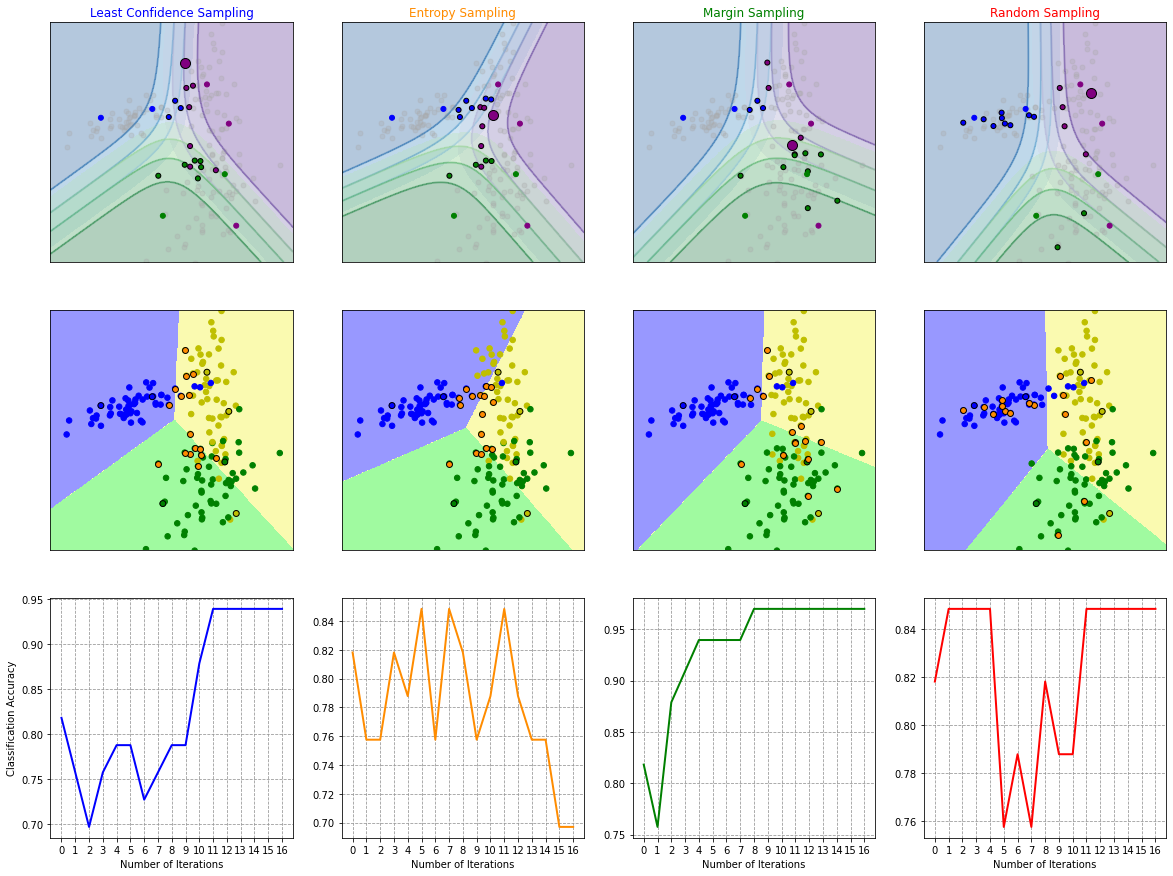

In [76]:
model_LR = LogisticRegression(max_iter=10000)

sampling_dict_class_animate = {
    "Least Confidence Sampling": {
        "model": clone(model_LR),
        "query_strat": uncertainty_sampling,
        "score": [],
        "marker": "o",
        "type": "uncertanity",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "blue",
        "save_dec": "Least Confidence Decision",
        "X_pool": None,
        "y_pool": None,
    },
    "Entropy Sampling": {
        "model": clone(model_LR),
        "query_strat": entropy_sampling,
        "score": [],
        "marker": "^",
        "type": "uncertanity",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "darkorange",
        "save_dec": "Entropy Sampling Decision",
        "X_pool": None,
        "y_pool": None,
    },
    "Margin Sampling": {
        "model": clone(model_LR),
        "query_strat": margin_sampling,
        "score": [],
        "marker": "s",
        "type": "uncertanity",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "green",
        "save_dec": "Margin Sampling Decision",
        "X_pool": None,
        "y_pool": None,
    },
    "Random Sampling": {
        "model": clone(model_LR),
        "query_strat": random_sampling,
        "score": [],
        "mean_score": [],
        "std_dev": [],
        "marker": "H",
        "type": "random",
        "n_iter": 50,
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "red",
        "save_dec": "Random Sampling Decision",
        "X_pool": None,
        "y_pool": None,
    },
}


animation = animate_classification(sampling_dict_class_animate, 3, 4, n_queries=16)
HTML(animation.to_html5_video())

### Classification for Multiclass dataset

In [77]:
def animate_classification_mnist(
    sampling_dict_class,
    model,
    grid_row=3,
    grid_col=4,
    n_queries=100,
    save_iter=0,
    train_size=750,
):
    if pml.is_latexify_enabled():
        fig, ax = plt.subplots(grid_row, grid_col)
        pml.latexify(fig_width=6, fig_height=2.5)
        # plt.subplots_adjust(hspace=0.4)
        # plt.subplots_adjust(wspace=0.2)
        [[ax[row][col].grid(False) for row in range(grid_row)] for col in range(grid_col)]
        label_fontsize = 6
        tick_fontsize = 6
        annotate_fontsize = 4
        grid_linewidth = 0.4
        title_fontsize = 6
    else:
        fig, ax = plt.subplots(grid_row, grid_col, figsize=(10, 10))
        [[ax[row][col].grid(True) for row in range(grid_row)] for col in range(grid_col)]
        label_fontsize = 10
        tick_fontsize = 10
        grid_linewidth = 1
        title_fontsize = 10
        annotate_fontsize = 8

    # Get and split Data
    (train_pool_X, train_pool_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
    X_train, X_pool, y_train, y_pool = train_test_split(
        train_pool_X,
        train_pool_y,
        train_size=train_size,
        random_state=42,
        stratify=train_pool_y,
    )

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_pool = X_pool.reshape(X_pool.shape[0], -1)

    # Fit an active learning model and query a sample based on 3 different uncertanity sampling stratergies
    for key, value in sampling_dict_class.items():
        active_model = modAL.models.ActiveLearner(
            estimator=model,
            query_strategy=value["query_strat"],
            X_training=X_train,
            y_training=y_train,
        )
        query_idx, query_sample = active_model.query(X_pool, n_instances=1)
        value["sample"] = query_sample
        value["sample_label"] = y_pool[query_idx]

    # Make a dicitionary of queried point data and target
    queried_dict = {value["sample_label"][0]: value["sample"].reshape(1, -1) for value in sampling_dict_class.values()}

    # Fit the model
    model_fit = model.fit(X_train, y_train)

    # Iterate over different sampling stratergies
    for col, (key, value) in enumerate(sampling_dict_class.items()):

        # Plot 3 graphs for each uncertanity technique
        for row, graph_type in enumerate(["imshow", "probability", "uncertanity"]):

            if graph_type == "imshow":
                ax[row][col].grid(False)
                ax[row][col].imshow(value["sample"].reshape(28, 28))
                ax[row][col].set_xticks(())
                ax[row][col].set_yticks(())
                title = f"{key} sampling"

            elif graph_type == "probability":
                proba = model_fit.predict_proba(value["sample"])

                # Plot probability bars
                ax[row][col].bar(
                    [i for i in range(10)],
                    proba.squeeze(),
                    color=value["color_scheme"],
                    zorder=2,
                )

                # Sort Probability list to find max_proba and second_max_proba
                proba_sorted = sorted(proba.squeeze().tolist(), reverse=True)

                max_proba = proba_sorted[0]
                second_max_proba = None

                for prob in proba_sorted:
                    if prob < max_proba:
                        second_max_proba = prob
                        break

                # Annotate patches
                patches_list = ax[row][col].patches

                for bar in patches_list:
                    cx = bar.get_x() + bar.get_width() / 2
                    cy = bar.get_height() + 0.05

                    if bar.get_height() in [max_proba, second_max_proba]:
                        ax[row][col].annotate(
                            f"{bar.get_height():.4f}",
                            (cx, cy),
                            color="black",
                            weight="bold",
                            fontsize=annotate_fontsize,
                            ha="center",
                            va="center",
                            zorder=2,
                        )

                    if bar.get_height() == max_proba:
                        bar.set_color("dimgrey")
                    elif second_max_proba != None and bar.get_height() == second_max_proba:
                        bar.set_color("lightgray")

                # Set graphing options
                ax[row][col].set_xlabel("Predicted Digit", fontsize=label_fontsize)
                ax[row][col].set_xticks(np.arange(10))
                plt.setp(ax[row][col].get_xticklabels(), fontsize=tick_fontsize)
                ax[row][col].set_ylim(0, 0.6)
                plt.setp(ax[row][col].get_yticklabels(), fontsize=tick_fontsize)

                # Add y_label to only the first columns
                if col == 0:
                    ax[row][col].set_ylabel("Probability", fontsize=label_fontsize)

                # Remove ticks from columns without affecting grid lines
                if col != 0:
                    for tick in ax[row][col].yaxis.get_major_ticks():
                        tick.tick1line.set_visible(False)
                        tick.tick2line.set_visible(False)
                        tick.label1.set_visible(False)
                        tick.label2.set_visible(False)

            elif graph_type == "uncertanity":

                # Dictionary to store the uncertanity values

                plotting_dict = {i: 0 for i in queried_dict.keys()}

                # Calculate the uncertanities for each of the next samples using
                # all 3 different uncertanity sampling techniques
                for key_, value_ in queried_dict.items():
                    if key == "Least Confidence":
                        leastc_uncert = classifier_uncertainty(model_fit, value_)
                        plotting_dict[key_] = leastc_uncert[0]
                        annotation_height = 0.015
                        rot = -90
                        ax[row][col].set_xlabel("Least Confidence Uncertanity", fontsize=label_fontsize)
                        # print(f"Probabilities (Least Confidence strat) for {key_} is {model.predict_proba(value_.reshape(1, -1))}")
                        # print(f"Least Confidence uncertanity for sample {key_} trained using {key} sampling is \n {1-np.max(model.predict_proba(value_.reshape(1, -1)))}")
                    elif key == "Entropy":
                        entropy_uncert = classifier_entropy(model_fit, value_)
                        plotting_dict[key_] = entropy_uncert[0]
                        annotation_height = 0.04
                        rot = -90
                        ax[row][col].set_xlabel("Entropy", fontsize=label_fontsize)
                        # print(f"Probabilities (Entropy strat) for {key_} is {model.predict_proba(value_.reshape(1, -1))}")
                        # print(f"Entropy for sample {key_} trained using {key} sampling is \n {entropy(model.predict_proba(value_.reshape(1, -1)).T)}")
                    elif key == "Margin":
                        margin_uncert = classifier_margin(model_fit, value_)
                        plotting_dict[key_] = -1 * margin_uncert[0]
                        annotation_height = -1 * 0.0006
                        rot = 90
                        ax[row][col].set_xlabel("Margin Uncertanity", fontsize=label_fontsize)
                        # print(f"Probabilities (Margin Sampling strat) for {key_} is {model.predict_proba(value_.reshape(1, -1))}")

                    # print("-------------------------------------------------")
                # print("_____________________________________________________")

                # Plot the remaining bars left out after max_proba and second_max_proba
                ax[row][col].barh(
                    [f"{t}" for t in queried_dict.keys()],
                    [plotting_dict[key_] for key_ in queried_dict.keys()],
                    color=value["color_scheme"],
                    zorder=2,
                )

                # Annotate plots
                for bar in ax[row][col].patches:
                    cx = bar.get_x() + bar.get_width() + annotation_height
                    cy = bar.get_y() + bar.get_height() / 2

                    ax[row][col].text(
                        cx,
                        cy,
                        f"{bar.get_width():.2f}",
                        rotation=rot,
                        color="black",
                        fontsize=annotate_fontsize,
                        ha="center",
                        va="center",
                        zorder=2,
                        weight="bold",
                    )

                # Graphing Options
                if col != 0:
                    for tick in ax[row][col].yaxis.get_major_ticks():
                        tick.tick1line.set_visible(False)
                        tick.tick2line.set_visible(False)
                        tick.label1.set_visible(False)
                        tick.label2.set_visible(False)
                else:
                    ax[row][col].set_ylabel("Digits", fontsize=label_fontsize)

                plt.setp(ax[row][col].get_xticklabels(), fontsize=tick_fontsize)
                plt.setp(ax[row][col].get_yticklabels(), fontsize=tick_fontsize)

    plt.subplots_adjust(wspace=0.2)

    fig.tight_layout()

    if pml.is_latexify_enabled():
        pml.savefig("MNIST Plot")

    fig.show()

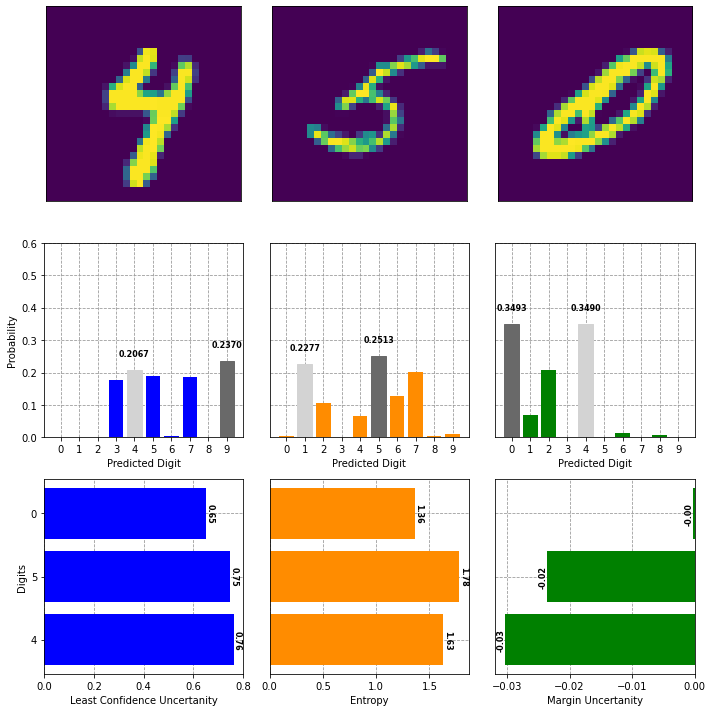

In [78]:
sampling_dict_class_animate = {
    "Least Confidence": {
        "color_scheme": "blue",
        "sample_label": None,
        "sample": None,
        "query_strat": uncertainty_sampling,
    },
    "Entropy": {
        "color_scheme": "darkorange",
        "sample_label": None,
        "sample": None,
        "query_strat": entropy_sampling,
    },
    "Margin": {
        "color_scheme": "green",
        "sample_label": None,
        "sample": None,
        "query_strat": margin_sampling,
    },
}

# animate_classification_mnist(sampling_dict_class_animate,LogisticRegression(max_iter=1000), 3,3, n_queries=5,save_iter=3,train_size=270)
animate_classification_mnist(
    sampling_dict_class_animate,
    LogisticRegression(max_iter=1000),
    3,
    3,
    n_queries=5,
    save_iter=3,
    train_size=140,
)

<a name="Animation_Uncert_MNIST"></a>

### Animation Regression

In [79]:
def reg_line_save(
    i,
    X_train,
    X_pool,
    y_train,
    y_pool,
    X_train_qry,
    y_train_qry,
    X_test_sorted,
    y_pred_sorted,
    rmse,
    std_dev_pts,
    save_name,
):
    fig = plt.figure()
    ax = plt.gca()

    pml.latexify(width_scale_factor=3)

    ax.scatter(
        np.append(X_train, X_pool),
        np.append(y_train, y_pool),
        c="lightgray",
        alpha=0.5,
        label=f"Pool Points",
    )
    ax.scatter(X_train, y_train, c="tab:red", label=f"Train Points", zorder=2)

    if i != 0:
        ax.scatter(
            X_train_qry[-i:],
            y_train_qry[-i:],
            c="limegreen",
            edgecolor="black",
            s=18,
            linewidth=0.75,
            label=f"Queried Points",
            zorder=3,
        )
        # ax.set_title(f"RMSE after {i} queries {rmse:.3f}" )
    else:
        # ax.set_title(f"RMSE for fit on train data {rmse:.3f}" )
        pass

    sns.despine()
    ax.plot(X_test_sorted, y_pred_sorted, c="black", marker="None")
    ax.fill_between(
        X_test_sorted,
        y_pred_sorted - 2 * std_dev_pts,
        y_pred_sorted + 2 * std_dev_pts,
        color="mediumseagreen",
        alpha=0.25,
    )
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.legend(loc="upper left", fontsize=5)
    pml.savefig(save_name)

In [81]:
def animate_regression(sampling_dict_class, grid_row=2, grid_col=2, n_queries=100):

    # Make a plot
    fig, ax = plt.subplots(grid_row, grid_col, figsize=(10, 10))
    camera = Camera(fig)

    # Split data
    X_test, X_train, X_pool, y_test, y_train, y_pool = make_animation_data_reg(initial_train_size=6)

    # Active Learning Loop
    for uncert_key, uncert_val in sampling_dict_class.items():
        (
            uncert_val["queries_np_X"],
            uncert_val["queries_np_y"],
            uncert_val["score"],
            uncert_val["X_pool"],
            uncert_val["y_pool"],
            uncert_val["st_dev_pts"],
        ) = uncert_results(
            uncert_val["model"],
            uncert_val["query_strat"],
            "Regression",
            uncert_key,
            n_queries=n_queries,
            X_pool=X_pool,
            y_pool=y_pool,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
        )

    # Loop over each iteration of the each query startergy
    for i in range(n_queries + 1):

        X_reg_line = None
        y_reg_line = None

        for col, (key, value) in enumerate(sampling_dict_class.items()):

            # Setup data for training
            if i == 0:
                X_train_qry = X_train
                y_train_qry = y_train
            else:
                X_train_qry = np.append(X_train, value["queries_np_X"][:i])
                y_train_qry = np.append(y_train, value["queries_np_y"][:i])

            X_pool_final = np.array(value["X_pool"])
            y_pool_final = np.array(value["y_pool"])

            # Model fit
            model_qry = clone(uncert_val["model"]).fit(X_train_qry.reshape(-1, 1), y_train_qry)

            # Make Predictions
            y_pred = model_qry.predict(X_test)

            # Sort X_test to plot the curve
            X_test_argsort = np.argsort(X_test.squeeze())
            X_test_sorted = X_test[X_test_argsort].squeeze()

            # Sort the predictions as well
            y_pred_sorted = y_pred[X_test_argsort].squeeze()

            # Sort std devs
            y_test_stddev_pts = value["st_dev_pts"][i][X_test_argsort]

            # Make 2 plots for each query stratergy
            for row, graph_type in enumerate(["reg_line", "accuracy_line"]):

                if graph_type == "reg_line":

                    ax[row][col].scatter(X_pool, y_pool, c="gray", alpha=0.5, label=f"Pool Points")

                    ax[row][col].scatter(X_train, y_train, c="red", label=f"Train Points")

                    if i != 0:
                        ax[row][col].scatter(
                            X_train_qry[-i:],
                            y_train_qry[-i:],
                            c="limegreen",
                            edgecolor="black",
                            label=f"Queried Points",
                        )
                        ax[row][col].scatter(
                            X_train_qry[-1],
                            y_train_qry[-1],
                            c="limegreen",
                            edgecolor="black",
                            s=50,
                            zorder=3,
                            label=f"Queried Points+{i}",
                        )

                    ax[row][col].plot(X_test_sorted, y_pred_sorted, c="black", marker="None")
                    ax[row][col].fill_between(
                        X_test_sorted,
                        y_pred_sorted - 2 * y_test_stddev_pts,
                        y_pred_sorted + 2 * y_test_stddev_pts,
                        color="mediumseagreen",
                        alpha=0.25,
                    )
                    ax[row][col].set_xlabel("X")
                    ax[row][col].set_ylabel("y")
                    ax[row][col].set_title(key)

                    if i in [0, 4] and pml.is_latexify_enabled() and value["save_dec"]:
                        print(f"RMSE on iter {i} for query strat {key} is {value['score'][i]}")
                        reg_line_save(
                            i,
                            X_train,
                            X_pool,
                            y_train,
                            y_pool,
                            X_train_qry,
                            y_train_qry,
                            X_test_sorted,
                            y_pred_sorted,
                            value["score"][i],
                            y_test_stddev_pts,
                            f"{value['save_dec']}_reg_iter_{i}",
                        )

                elif graph_type == "accuracy_line":

                    ax[row][col].grid(True)

                    if i == 0:
                        ax[row][col].plot([i], value["score"][i], color=value["color_scheme"])
                    else:
                        ax[row][col].plot(
                            [itr for itr in range(i + 1)],
                            value["score"][: i + 1],
                            color=value["color_scheme"],
                        )
                        ax[row][col].set_xticks([i for i in range(0, i + 1, 2)])

                    ax[row][col].set_xlabel("Number of Iterations")

                    if col == 0:
                        ax[row][col].set_ylabel("RMSE")

        plt.subplots_adjust(hspace=0.2)

        camera.snap()

    animation = camera.animate(interval=500, blit=True)
    return animation

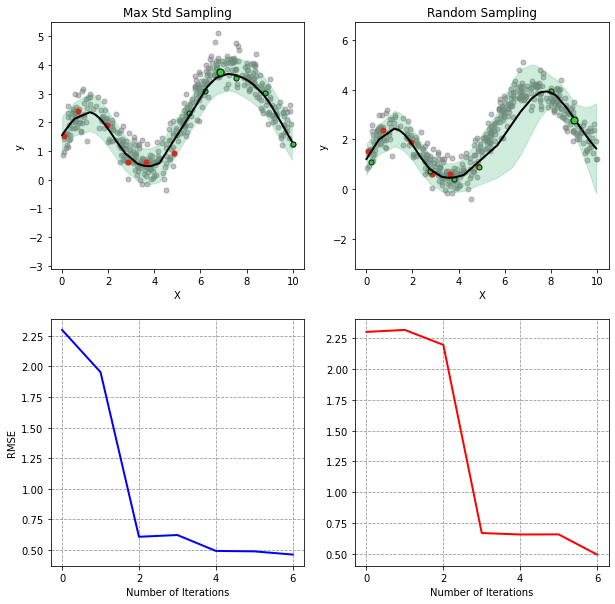

In [82]:
warnings.filterwarnings("ignore")

sampling_dict_reg_animate = {
    "Max Std Sampling": {
        "model": clone(model_0),
        "query_strat": max_std_sampling,
        "score": [],
        "std_dev_pts": [],
        "marker": "o",
        "type": "uncertanity",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "blue",
        "save_dec": "Least Confidence Decision",
        "X_pool": None,
        "y_pool": None,
        "save_dec": "Max_Std_Sampling_",
    },
    "Random Sampling": {
        "model": clone(model_0),
        "query_strat": random_sampling,
        "score": [],
        "st_dev_pts": [],
        "marker": "H",
        "type": "random",
        "queries_np_X": None,
        "queries_np_y": None,
        "color_scheme": "red",
        "save_dec": "Random Sampling Decision",
        "X_pool": None,
        "y_pool": None,
        "save_dec": "Random_Sampling_",
    },
}

animation = animate_regression(sampling_dict_reg_animate, 2, 2, n_queries=6)
HTML(animation.to_html5_video())

<a name="Animation_Uncert_Reg"></a>